In [ ]:
!pip install transformers

In [2]:
#https://huggingface.co/deepset/bert-large-uncased-whole-word-masking-squad2
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("deepset/bert-large-uncased-whole-word-masking-squad2")
bert_model = AutoModelForQuestionAnswering.from_pretrained("deepset/bert-large-uncased-whole-word-masking-squad2",return_dict=False)

In [4]:
# Text obtained from Wikipedie.org
question = "Which models can be used for NLP related tasks?"
context = "Many pretrained models such as GPT-3, GPT-2, BERT, XLNet, and RoBERTa demonstrate the ability of Transformers to perform a wide variety of such NLP-related tasks, and have the potential to find real-world applications"

In [5]:
# Determine the input ids for both question and context
inputids = tokenizer.encode(question, context)
print(f'The input tokens are {str(len(inputids))}')

The input tokens are 66


In [6]:
# Using Bert Tokenizer tokenize the inputids and store in a dictionary S.
tokenz = tokenizer.convert_ids_to_tokens(inputids)
s={}
for token, id in zip(tokenz, inputids):
  s[token] = id

In [7]:
# Display the dictionary that contains the tokens / embeddings for both question and context
print(s)

{'[CLS]': 101, 'which': 2029, 'models': 4275, 'can': 2064, 'be': 2022, 'used': 2109, 'for': 2005, 'nl': 17953, '##p': 2361, 'related': 3141, 'tasks': 8518, '?': 1029, '[SEP]': 102, 'many': 2116, 'pre': 3653, '##train': 23654, '##ed': 2098, 'such': 2107, 'as': 2004, 'gp': 14246, '##t': 2102, '-': 1011, '3': 1017, ',': 1010, '2': 1016, 'bert': 14324, 'xl': 28712, '##net': 7159, 'and': 1998, 'roberta': 23455, 'demonstrate': 10580, 'the': 1996, 'ability': 3754, 'of': 1997, 'transformers': 19081, 'to': 2000, 'perform': 4685, 'a': 1037, 'wide': 2898, 'variety': 3528, 'have': 2031, 'potential': 4022, 'find': 2424, 'real': 2613, 'world': 2088, 'applications': 5097}


In [8]:
  # Use the bert_model to determine the answer
  # We will be using pytorch. It comes with the Colab session
  import torch

  # search the inputids for the first instance of the '[SEP]' token.
  sep_index = inputids.index(tokenizer.sep_token_id)

# The number of segement A tokens include the [SEP] token itself.
  typeA = sep_index + 1

# The remainder are segment B
  typeB = len(inputids) - typeA

# The model's second parameter is Type_ids, build the list of 0s and 1s
  Type_ids = [0]*typeA + [1]*typeB

# capture the scores for the plots. Score1 is the start score and score2 is the end score
  score1, score2 = bert_model(torch.tensor([inputids]), token_type_ids=torch.tensor([Type_ids]))

# Obtaint the tokens for the final answer start and final answer end using argmax
  final_answer = ' '.join(tokenz[torch.argmax(score1):torch.argmax(score2)+1])

  print(f' The final answer is: {final_answer}')

 The final answer is: gp ##t - 3 , gp ##t - 2 , bert , xl ##net , and roberta


**bold text** It correctly guessed the answer with sub-word ## above.

In [9]:
# Steps to remove the ## from the sub-word token
first_token = tokenz[torch.argmax(score1)]

for index in range(torch.argmax(score1) + 1, torch.argmax(score2) + 1):
    
    if tokenz[index][0:2] == '##':
        first_token += tokenz[index][2:]
    
    else:
        first_token += ' ' + tokenz[index]

print('Meaningful Answer: "' + first_token + '"')

Meaningful Answer: "gpt - 3 , gpt - 2 , bert , xlnet , and roberta"


In [11]:
# To visualize the start and end answer tokens, create two new dictionaries
# Flatten the scores from the model into a single dimension array
s_scores = score1.detach().numpy().flatten()
e_scores = score2.detach().numpy().flatten()
start={}
for token, id in zip(tokenz, s_scores):
  start[token] = id
end={}
for token, id in zip(tokenz, e_scores):
  end[token] = id

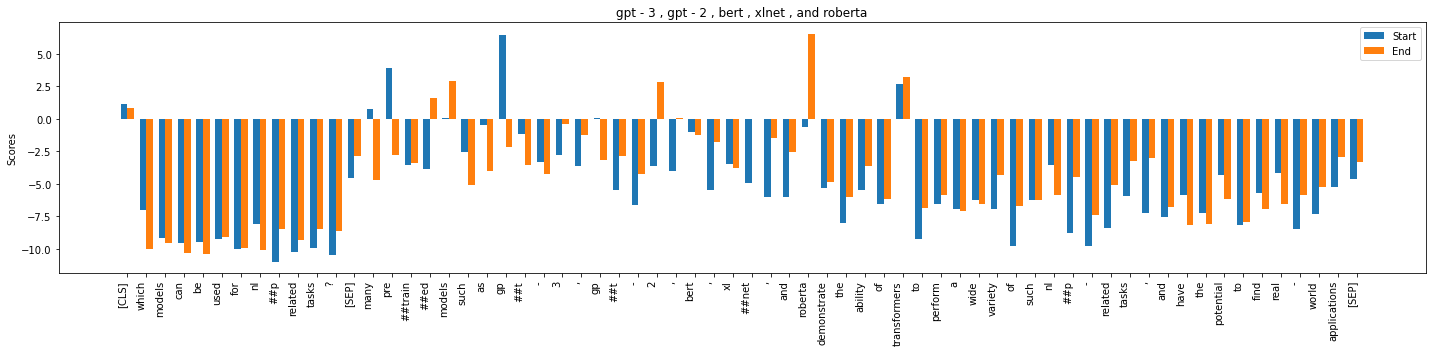

In [12]:
# Plot a grouped bar chart to show the start to end output tokens
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = tokenz
start_means = s_scores
end_means = e_scores
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 5))
rects1 = ax.bar(x - width/2, start_means, width, label='Start')
rects2 = ax.bar(x + width/2, end_means, width, label='End')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title(first_token)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical', ha='right')
ax.legend()

fig.tight_layout()

plt.show()

In [30]:
bert_abstract = 'The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denvers defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.'

In [57]:
import textwrap

dedented_text = textwrap.dedent(bert_abstract).strip()
for width in [ 80 ]:
        print('-'*80)
        #print('%d Columns:\n' % width)
        print(textwrap.fill(dedented_text, width=width))
        print('-'*80)

--------------------------------------------------------------------------------
The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was
limited by Denvers defense, which sacked him seven times and forced him into
three turnovers, including a fumble which they recovered for a touchdown. Denver
linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½
sacks, and two forced fumbles.
--------------------------------------------------------------------------------


In [58]:
# Create a function using code in line # 16 and then obtain the results below.
def QandA(new_question, bert_abstract):
  input_ids = tokenizer.encode(new_question, bert_abstract)
  tokenz = tokenizer.convert_ids_to_tokens(input_ids)
  sep_index = input_ids.index(tokenizer.sep_token_id)
  A = sep_index + 1
  B = len(input_ids) - A
  Type_ids = [0]*A + [1]*B
  score3, score4 = bert_model(torch.tensor([input_ids]), token_type_ids=torch.tensor([Type_ids]))
  final_answer = ' '.join(tokenz[torch.argmax(score3):torch.argmax(score4)+1])
  print(f' The final answer is: {final_answer}')


In [59]:
new_question = "Which city won the Super Bowl?"
QandA(new_question, bert_abstract)

 The final answer is: denver


In [60]:
new_question = "Who won the Super Bowl?"
QandA(new_question, bert_abstract)

 The final answer is: the broncos


In [61]:
new_question = "Who became the MVP?"
QandA(new_question, bert_abstract)

 The final answer is: von miller
